In [1]:
import gdrive_refs as names
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

After importing the Python libraries, we load the datasets into a dictionary name `datasets`

In [3]:
root = "./../data/"
datasets = dict()
for name in names.gdrive_dic:
    address = root+name[1]
    datasets[name[1]] = pd.read_csv(address, on_bad_lines='skip')

# Can we infer annual death tolls attributable to air pollution with AQI?

One of our goals in this project is to relate deaths tolls of air pollution to the data we have in the dataset of the class. A first idea that came to our mind was to use $AQI$ for Air Quality Index. It is metrics used to depict air quality based on the concentration of pollutants in the air.

### _Why would we use $AQI$?_

$AQI$ is a convenient index that not only indicates well whether the air is dangerous for health, but is also much more accessible to the public. In fact states usually give $AQI$s and not the concentrations of pollutants measured in the outdoor air. ([Here](https://www.airnow.gov/aqi/aqi-calculator/) is an example) 

However, we saw by doing digging on our end that it is easier to relate deaths to the $PM2.5$, a measurement of density of polluting particules over a 24h time window. One way to do it is to use data from the WHO and relate deaths to $PM2.5$. This way we would like to create a data pipeline that would help anyone assess attributable deaths due to pollution with accessible data (here $AQI$).

### _Initial methodology_

We want to first create data pipeline: $ AQI \rightarrow PM2.5 \rightarrow Attributable\;Deaths$. In this way, we want to infer deaths attributable to air pollution using $AQIs$. However the data we find available online as a validation set begins at the year 2001 and stops at the year 2016. This way we will be doing inferencing on $AQI$s data from the years 2001 to 2016 from the Environmental Protection Agency ([EPA](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Annual)). We will show that this method is unfortunately inaccurate as there is not a linear relationship between $AQI$ and $PM2.5$. Instead we will fit a *Sigmoid function* based on the computation of $AQIs$ and

# _EDA_

**Creating the jointed dataset of $AQIs$ from 2001 to 2016 with `pandas`**

In [21]:
years = [str(i) for i in range(2001,2017)]
annual_aqi_us_county = datasets["annual_aqi_by_county_2000.csv"].loc[:,['Year', 'State', 'County','Median AQI']]
increment = 1
for year in years:
    df = datasets["annual_aqi_by_county_"+year+".csv"].loc[:,['Year', 'State', 'County','Median AQI']]
    annual_aqi_us_county = pd.concat([annual_aqi_us_county, df], axis=0)
    increment += 1
annual_aqi_us_county = annual_aqi_us_county.reset_index().drop(columns='index')

Printing for checking

In [22]:
annual_aqi_us_county

,Year,State,County,Median AQI
0,2000,Alabama,Baldwin,54
1,2000,Alabama,Clay,46
2,2000,Alabama,Colbert,16
3,2000,Alabama,DeKalb,51
4,2000,Alabama,Elmore,50
...,...,...,...,...
18810,2016,Wyoming,Sublette,44
18811,2016,Wyoming,Sweetwater,44
18812,2016,Wyoming,Teton,41
18813,2016,Wyoming,Uinta,42


<AxesSubplot:xlabel='Year', ylabel='Median AQI'>

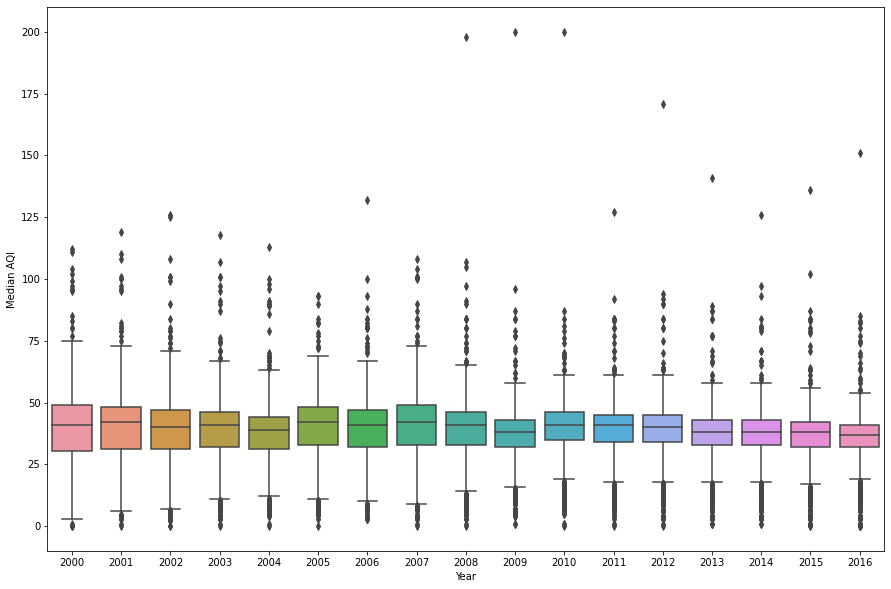

In [30]:
plt.figure(figsize=(15,10))
sns.boxplot(data = annual_aqi_us_county, x='Year', y='Median AQI')

**Creating the jointed dataset of $PM2.5s$ from 2001 to 2016 with `pandas`**

In [6]:
pm25_county = datasets["Daily_PM25_Concentrations_All_County_2001-2016.csv"]
pm25_county

,year,date,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
0,2001,01JAN2001,1,1,10.664367,10.264546,10.137631,10.188703
1,2001,01JAN2001,1,3,9.803209,8.739505,8.743748,8.811486
2,2001,01JAN2001,1,5,12.087599,11.809159,11.812775,11.802062
3,2001,01JAN2001,1,7,8.579425,8.435394,8.458118,8.448871
4,2001,01JAN2001,1,9,14.399446,13.577741,13.300528,13.231461
...,...,...,...,...,...,...,...,...
18168991,2016,31DEC2016,56,37,9.436500,7.100500,7.251233,7.260799
18168992,2016,31DEC2016,56,39,4.195300,3.823850,3.674600,3.746709
18168993,2016,31DEC2016,56,41,17.849100,16.394300,15.252833,15.363383
18168994,2016,31DEC2016,56,43,2.907300,2.801800,2.667467,2.635025


Quick EDA shows that datasets diverge for multiple reasons:

1. `Daily_PM25_Concentrations_All_County_2001-2016.csv` gives daily $PM2.5$ concentration on all counties of the state. Further processing will therefore required: estimating the average $PM2.5$ along the years and counties, and most of all mapping the `statefips` and `countyfips` into the actual name of the county.
2. `annual_aqi_us_county` dataframe does not embedd states nor county fips, which would be interesting to do in case $AQI$ is uncorrelated to $PM2.5$. 

The following will be about processing the `Daily_PM25_Concentrations_All_County_2001-2016.csv` table to create an inner joint with `annual_aqi_us_county` on the county name.

In [7]:
pm25_county = pm25_county.groupby(['year','statefips','countyfips']).mean().reset_index()

Converting `statefips` and `countyfips` into `fip` series.

In [10]:
def get_national_county_fips(statefips: int, countyfips: int):
    state = str(statefips)
    county = str(countyfips)
    if len(state) < 2:
        nb_zeros_state = 2 - len(state)
        state = '0' * nb_zeros_state + state
    if len(county) < 3:
        nb_zeros_county = 3 - len(county)
        county = '0' * nb_zeros_county + county
    return state + county

pm25_county['fip'] = pd.Series(map(get_national_county_fips, pm25_county['statefips'],pm25_county['countyfips']))
pm25_county

,year,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,fip
0,2001,1,1,13.186807,12.834644,12.784293,12.802367,01001
1,2001,1,3,12.520190,10.932646,10.942949,10.998630,01003
2,2001,1,5,12.364383,11.970003,11.923674,11.911162,01005
3,2001,1,7,13.944184,13.245489,13.287072,13.235569,01007
4,2001,1,9,16.032861,14.993545,15.047098,15.048776,01009
...,...,...,...,...,...,...,...,...
49739,2016,56,37,5.764629,4.997065,5.014473,5.022341,56037
49740,2016,56,39,5.296705,4.792083,4.751971,4.773778,56039
49741,2016,56,41,6.231125,5.816084,5.804105,5.808088,56041
49742,2016,56,43,4.110221,4.042611,3.893485,3.863789,56043


In [12]:
fips_usa = datasets["fips_code.csv"].reset_index().iloc[1:,:]
fips_usa = fips_usa.rename(columns={'level_0':'fip','level_1':'County'})

pm25_county = pm25_county.merge(right = fips_usa, left_on='fip', right_on='fip')
pm25_county


,year,statefips,countyfips,PM25_max_pred,PM25_med_pred,PM25_mean_pred,PM25_pop_pred,fip,County,Table 1
0,2001,10,1,15.031078,14.149036,14.169766,14.185106,10001,Kent,DE
1,2002,10,1,13.601891,12.779641,12.801293,12.822703,10001,Kent,DE
2,2003,10,1,13.763596,12.941987,12.978132,12.997419,10001,Kent,DE
3,2004,10,1,13.427100,12.616662,12.645840,12.661785,10001,Kent,DE
4,2005,10,1,13.764080,12.854004,12.888077,12.908124,10001,Kent,DE
...,...,...,...,...,...,...,...,...,...,...
45147,2012,56,45,6.729819,6.539296,6.539296,6.535289,56045,Weston,WY
45148,2013,56,45,5.349066,5.219321,5.219321,5.218880,56045,Weston,WY
45149,2014,56,45,4.148008,4.000508,4.000508,4.000164,56045,Weston,WY
45150,2015,56,45,5.188238,4.964421,4.964421,4.972800,56045,Weston,WY


In [13]:
pm25_county = pm25_county.groupby(['year','County']).mean().reset_index().loc[:,['year','County','PM25_med_pred', 'PM25_mean_pred', 'PM25_pop_pred']]
pm25_county

,year,County,PM25_med_pred,PM25_mean_pred,PM25_pop_pred
0,2001,Abbeville,13.668552,13.677685,13.657766
1,2001,Acadia,10.662103,10.690537,10.717784
2,2001,Accomack,11.722835,11.709921,11.717420
3,2001,Ada,9.848206,9.850271,9.919391
4,2001,Adair,11.449971,11.453552,11.451338
...,...,...,...,...,...
26651,2016,York,7.756900,7.729703,7.731704
26652,2016,Young,6.718434,6.720331,6.717203
26653,2016,Zapata,7.030474,7.030211,7.030512
26654,2016,Zavala,6.723998,6.716751,6.734031


In [14]:
annual_aqi_us = annual_aqi_us_county.groupby(['Year','County']).mean().reset_index()
annual_aqi_us

,Year,County,Median AQI
0,2000,Abbeville,54.000000
1,2000,Ada,32.000000
2,2000,Adams,42.500000
3,2000,Aiken,41.000000
4,2000,Alachua,37.000000
...,...,...,...
14241,2016,Yavapai,40.000000
14242,2016,Yellowstone,22.000000
14243,2016,Yolo,40.000000
14244,2016,York,39.333333


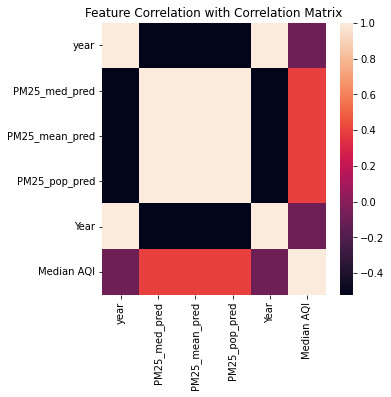

       year       County  PM25_med_pred  PM25_mean_pred  PM25_pop_pred  Year  \
0      2001    Abbeville      13.668552       13.677685      13.657766  2001   
1      2001          Ada       9.848206        9.850271       9.919391  2001   
2      2001        Adams      11.215387       11.196987      11.199464  2001   
3      2001        Aiken      14.273415       14.212441      14.237075  2001   
4      2001      Alachua      10.946459       10.955627      10.963076  2001   
...     ...          ...            ...             ...            ...   ...   
11110  2016       Yakima       7.812249        7.634759       7.668087  2016   
11111  2016    Yalobusha       8.435838        8.435100       8.432523  2016   
11112  2016       Yancey       7.847097        7.862268       7.863233  2016   
11113  2016  Yellowstone       5.901779        5.813483       5.785077  2016   
11114  2016         York       7.756900        7.729703       7.731704  2016   

       Median AQI  
0       50.000000  

/Users/aymeric/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: Could not interpret value `Median AQI` for parameter `y`

<Figure size 432x288 with 0 Axes>

In [16]:
joined_aqi_pm25_us = pm25_county.merge(annual_aqi_us, left_on = ['year','County'], right_on = ['Year','County'])

plt.figure(figsize=(5,5))
sns.heatmap(joined_aqi_pm25_us.corr())
plt.title("Feature Correlation with Correlation Matrix")
plt.show()

print(joined_aqi_pm25_us)

plt.figure()
sns.scatterplot(joined_aqi_pm25_us, x = 'PM25_mean_pred', y='Median AQI')
#plt.xlabel('PM25_mean_pred')
plt.show()


Making a linear Machine Learning model out of this plot looks impossible. Looking at what is available online, we see that taking the median of $AQIs$. In fact the formula to calculate $AQI$ with $PM2.5$ is:

$$AQI = \frac{I_{Hi}-I_{Lo}}{BP_{Hi}-BP_{Lo}}(PM2.5-BP_{Lo})+I_{Lo}$$

Where:
| Variable | Explanation |
| --- | --- |
| $BP$ | the Breaking Point of PM2.5 in its corresponding range |
| $I$ | the Breaking Point of AQI in its corresponding range |

This means that with reasonable variations of PM2.5 is a union of linear segments. **Note that the measurements are taken on a 24h time window.**

In [132]:
from IPython.core.display import Image, display
Image(url='https://www.airveda.com/resources/images/aqi_calculation_update/chart.png')

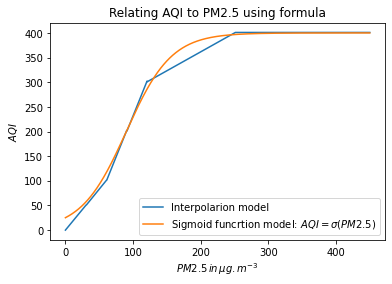

In [167]:
def aqi(x):
    if 0<=int(x)<=30:
        return(50/30*x)
    if 31<=int(x)<=60:
        return(49/29*(x-31)+51)
    if 61<=int(x)<=90:
        return((200-101)/(90-61)*(x-61)+101)
    if 91<=int(x)<=120:
        return(99/(120-91)*(x-91)+201)
    if 121<=int(x)<=250:
        return((400-301)/(250-121)*(x-121)+301)
    if 251<=int(x):
        return(401)
    else:
        return(0)

x_pm25 = np.linspace(0,450,900)
y_aqi = [aqi(e) for e in x_pm25]
y_pred_aqi = 400/(1+np.exp(0.03*(-x_pm25+90)))

plt.figure()
plt.plot(x_pm25,y_aqi, label = 'Interpolarion model')
plt.plot(x_pm25,y_pred_aqi, label = 'Sigmoid function model: $AQI = \sigma(PM2.5)$')
plt.xlabel("$PM2.5 \, in \, \mu g.m^{-3}$")
plt.ylabel("$AQI$")
plt.title("Relating AQI to PM2.5 using formula")
plt.legend()
plt.show()

As displayed above, the function looks awfully like a **Sigmoid Function** with the following equation:

$$AQI(PM2.5)=\frac{400}{1+e^{-0.04\times(PM2.5-90)}}$$

... which we plotted in orange above for reference

# Conclusion

The decorrelation of annual median AQIs and annual mean PM2.5 make now much more sense since we are correlating an entry with the average of sigmoid functions. Not only there is no linear correlation between the two variables but there is also no simple transformation we can apply to the entries to correlate the two. As a result **it is not possible to relate annual deaths attributed to air pollution with median annual $AQI$**. We do not have a choice but to calculate 